# Difference in AMOC, barotropic streamfunction, sea ice, and deep convection between cold and warm period

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import cmocean 
from scipy.signal import welch
import seaborn as sns

In [2]:
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")
sns.set_style("ticks")

In [3]:
from dask.distributed import Client, LocalCluster, wait

In [4]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40639 instead
  expected, actual


In [5]:
client

Client Scheduler: tcp://127.0.0.1:45323 Dashboard: http://127.0.0.1:40639/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [6]:
#plt.style.use('dark_background')
#dark='_dark'
dark=''

In [7]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'

## Read NEMO mesh

In [8]:
# NEMO mesh
ds_mesh = xr.open_dataset(nemo_mesh)
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)

## Read NEMO stream functions

In [9]:
exp_list = ['FOCI_GJK001','FOCI_GJK006']
time_list = [slice('1850-01-01','2850-01-01'), slice('2850-01-01','3950-01-01')]

In [10]:
# NEMO derived
ds_moc_all = []
ds_psi_all = []
for exp,time in zip(exp_list,time_list):
    moc = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*MOC.nc' % (esmdir,exp,exp)
    print(moc)
    ds_moc = xr.open_mfdataset(moc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    
    lat = ds_moc['nav_lat'][0,:,0].data # .data is required in newer xarray versions
    ds_moc_lat = ds_moc.assign_coords(lat=("y", lat)) # add latitude to stream functions
    ds_moc_all.append(ds_moc_lat)
    
    psi = '%s/%s/outdata/nemo/cdf_analysis/%s*1y*PSI_r360x180.nc' % (esmdir,exp,exp)
    print(psi)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_psi = xr.open_mfdataset(psi,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_psi_all.append(ds_psi)

//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*MOC.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1y*PSI_r360x180.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/cdf_analysis/FOCI_GJK006*1m*MOC.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/cdf_analysis/FOCI_GJK006*1y*PSI_r360x180.nc


In [11]:
ds_psi = xr.concat( ds_psi_all, dim='time' )
ds_moc = xr.concat( ds_moc_all, dim='time' )

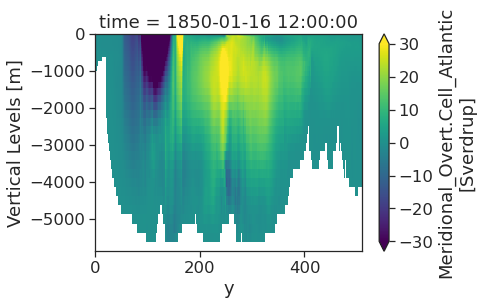

In [12]:
ds_moc['zomsfatl'].where(ds_moc['zomsfatl'] != 0).sel(x=0)[0,:,:].plot(vmin=-30,vmax=30)

## Read monthly NEMO data

In [13]:
# NEMO monthly
ds_nemo_t_all = []
for exp,time in zip(exp_list,time_list):
    t = '/%s/%s/outdata/nemo/r180x90/%s*1m*grid_T.nc' % (esmdir,exp,exp)
    print(t)
    ds_t = xr.open_mfdataset(t,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_nemo_t_all.append(ds_t)

//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/r180x90/FOCI_GJK001*1m*grid_T.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/r180x90/FOCI_GJK006*1m*grid_T.nc


In [14]:
ds_nemo_t = xr.concat(ds_nemo_t_all, dim='time')

In [15]:
ds_nemo_t

<xarray.Dataset>
Dimensions:            (time: 25200, bnds: 2, lon: 180, lat: 90, deptht: 46)
Coordinates:
  * time               (time) object 1850-01-16 12:00:00 ... 3949-12-16 12:00:00
  * lon                (lon) float64 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * lat                (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * deptht             (deptht) float32 3.047 9.454 ... 5.625e+03 5.875e+03
Dimensions without coordinates: bnds
Data variables: (12/18)
    time_counter_bnds  (time, bnds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    deptht_bnds        (time, deptht, bnds) float32 dask.array<chunksize=(120, 46, 2), meta=np.ndarray>
    votemper           (time, deptht, lat, lon) float32 dask.array<chunksize=(120, 46, 90, 180), meta=np.ndarray>
    vosaline           (time, deptht, lat, lon) float32 dask.array<chunksize=(120, 46, 90, 180), meta=np.ndarray>
    sosstsst           (time, lat, lon) float32 dask.array<chunksize=(120, 90, 180), meta=np.ndarray>
    sosaline           (time, lat, lon) float32 dask.array<chunksize=(120, 90, 180), meta=np.ndarray>
    ...                 ...
    sohefldo           (time, lat, lon) float32 dask.array<chunksize=(120, 90, 180), meta=np.ndarray>
    hflx_cal           (time, lat, lon) float32 dask.array<chunksize=(120, 90, 180), meta=np.ndarray>
    somxl010           (time, lat, lon) float32 dask.array<chunksize=(120, 90, 180), meta=np.ndarray>
    somixhgt           (time, lat, lon) float32 dask.array<chunksize=(120, 90, 180), meta=np.ndarray>
    sowindsp           (time, lat, lon) float32 dask.array<chunksize=(120, 90, 180), meta=np.ndarray>
    sobowlin           (time, lat, lon) float32 dask.array<chunksize=(120, 90, 180), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    name:         FOCI_GJK001_1m_18500101_18591231_grid_T
    description:  ocean T grid variables
    title:        ocean T grid variables
    timeStamp:    2021-Nov-12 19:21:54 GMT
    uuid:         928b9a2c-960f-4c37-b532-2f9456d34828
    history:      Wed Oct 19 08:14:21 2022: cdo -remapbil,r180x90 -setctomiss...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

## OpenIFS data 

In [16]:
# OpenIFS surface
ds_sfc_all = []
for exp,time in zip(exp_list,time_list):
    sfc = '%s/%s/outdata/oifs/*1m*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/*1m*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/oifs/*1m*regular_sfc.nc


In [17]:
ds_1m_sfc = xr.concat(ds_sfc_all, dim='time')

In [18]:
label_list = ['Phase1','Phase2','Phase3']

# New definition of phases based on analysing PC1
periods = [ [2000,2450], [2550,3150], [3300,3510] ]
period_list = []
period_list_yr = []
for p in periods:
    period_list.append(slice('%d-01-01' % (p[0],), '%d-01-01' % (p[1],)))
    period_list_yr.append(slice(p[0],p[1]))

## Deep convection

In [19]:
warm_period = period_list[0]
cold_period = period_list[1]

if 1:
    
    # Select March MLD
    _mld_mar = ds_nemo_t['somxl010'].sel(time=ds_nemo_t['somxl010'].time.dt.month.isin([3]))
    
    # Select all year
    _mld_y = ds_nemo_t['somxl010']
    
    # Select two periods
    _mld1 = _mld_mar.sel(time=warm_period).groupby('time.year').mean('time')
    _mld2 = _mld_mar.sel(time=cold_period).groupby('time.year').mean('time')
    
    _mld1_y = _mld_y.sel(time=warm_period).groupby('time.year').mean('time')
    _mld2_y = _mld_y.sel(time=cold_period).groupby('time.year').mean('time')
    
    # 20-100 year filter
    _mld1_f = _mld1.rolling(year=20).mean() - _mld1.rolling(year=100).mean()
    _mld2_f = _mld2.rolling(year=20).mean() - _mld2.rolling(year=100).mean()
    
    _mld1_f_y = _mld1_y.rolling(year=20).mean() - _mld1_y.rolling(year=100).mean()
    _mld2_f_y = _mld2_y.rolling(year=20).mean() - _mld2_y.rolling(year=100).mean()
    
    # Compute std diff
    mld_std_diff = (_mld2_f.std('year') - _mld1_f.std('year')).compute()
    mld_std_diff_y = (_mld2_f_y.std('year') - _mld1_f_y.std('year')).compute()

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


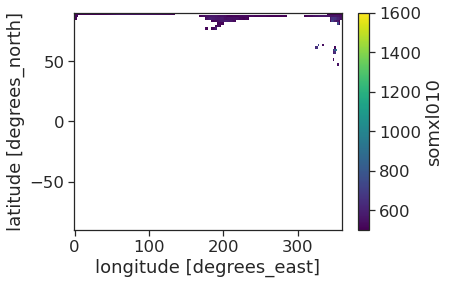

In [20]:
#_mld1.mean('year').where(_mld1.mean('year') > 500).plot(vmin=500, vmax=1600)
_mld2.mean('year').where(_mld2.mean('year') > 500).plot(vmin=500, vmax=1600)

## Sea ice

In [21]:
warm_period = period_list[0]
cold_period = period_list[1]

if 1:
    
    # Select February sea ice
    _ice_feb = ds_1m_sfc['ci'].sel(time=ds_1m_sfc['ci'].time.dt.month.isin([2]))
    
    # Select all year
    _ice_y = ds_1m_sfc['ci']
    
    # Select two periods
    _ice1 = _ice_feb.sel(time=warm_period).groupby('time.year').mean('time')
    _ice2 = _ice_feb.sel(time=cold_period).groupby('time.year').mean('time')
    
    _ice1y = _ice_y.sel(time=warm_period).groupby('time.year').mean('time')
    _ice2y = _ice_y.sel(time=cold_period).groupby('time.year').mean('time')
    
    # 20-100 year filter
    _ice1_f = _ice1.rolling(year=20).mean() - _ice1.rolling(year=100).mean()
    _ice2_f = _ice2.rolling(year=20).mean() - _ice2.rolling(year=100).mean()
    
    _ice1_fy = _ice1y.rolling(year=20).mean() - _ice1y.rolling(year=100).mean()
    _ice2_fy = _ice2y.rolling(year=20).mean() - _ice2y.rolling(year=100).mean()
    
    # Compute std diff
    ice_std_diff = (_ice2_f.std('year') - _ice1_f.std('year')).compute()
    ice_std_diff_y = (_ice2_fy.std('year') - _ice1_fy.std('year')).compute()

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [35]:
# heat fluxes
warm_period = period_list[0]
cold_period = period_list[1]

if 1:
    
    _thf = (ds_1m_sfc['sshf'] + ds_1m_sfc['slhf']) / (12*3600.)
    
    # Select two periods
    _thf1 = _thf.sel(time=warm_period).groupby('time.year').mean('time')
    _thf2 = _thf.sel(time=cold_period).groupby('time.year').mean('time')
    
    # 20-100 year filter
    _thf1_f = _thf1.rolling(year=20).mean() - _thf1.rolling(year=100).mean()
    _thf2_f = _thf2.rolling(year=20).mean() - _thf2.rolling(year=100).mean()
    
    # Compute std diff
    thf_std_diff = (_thf2_f.std('year') - _thf1_f.std('year')).compute()

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [34]:
ds_1m_sfc

<xarray.Dataset>
Dimensions:               (lat: 96, lon: 192, time: 25200, axis_nbounds: 2)
Coordinates:
  * lat                   (lat) float32 -89.06 -87.19 -85.31 ... 87.19 89.06
  * lon                   (lon) float32 0.9375 2.812 4.688 ... 355.3 357.2 359.1
    time_centered         (time) object dask.array<chunksize=(120,), meta=np.ndarray>
  * time                  (time) object 1850-01-16 12:00:00 ... 3949-12-16 12...
Dimensions without coordinates: axis_nbounds
Data variables: (12/43)
    time_centered_bounds  (time, axis_nbounds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    sstk                  (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    ci                    (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    es                    (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    tclw                  (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    ...                    ...
    swvl1                 (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    swvl2                 (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    swvl3                 (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    swvl4                 (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    sro                   (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    ssro                  (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
Attributes:
    name:         ECE3_1m_18500101_regular_sfc
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2021-Nov-12 19:21:56 GMT
    uuid:         0c810368-fe66-48aa-9163-86fa3ed8dac8
    history:      Sun Nov 14 21:27:08 2021: ncks -7 --no-alphabetize -L 1 --c...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

## Differences in time mean AMOC, PSI

In [22]:
warm_period = period_list[0]
cold_period = period_list[1]

if 1:
    
    ##
    ## Compute AMOC
    ## 
    print('Compute AMOC')
    _amoc1 = ds_moc['zomsfatl'].sel(x=0).sel(time=warm_period).groupby('time.year').mean('time').compute()
    _amoc2 = ds_moc['zomsfatl'].sel(x=0).sel(time=cold_period).groupby('time.year').mean('time').compute()
    
    ##
    ## Compute barotropic stream function
    ##
    print('Compute PSI')
    _baro1 = ds_psi['sobarstf'].sel(time=warm_period).groupby('time.year').mean('time').compute() * 1e-6
    _baro2 = ds_psi['sobarstf'].sel(time=cold_period).groupby('time.year').mean('time').compute() * 1e-6

    ##
    ## Differences, cold minus warm
    ##
    print('Compute diffs')
    amoc_diff = (_amoc2.mean('year') - _amoc1.mean('year'))
    baro_diff = (_baro2.mean('year') - _baro1.mean('year'))

    
    ##
    ## AMOC standard dev.
    ## Bandpass filter 20-100 yr
    ##
    print('Compute std of AMOC')
    run1,run2=20,100
    _amoc1_f = _amoc1.rolling(year=run1,center=True).mean() - _amoc1.rolling(year=run2,center=True).mean()
    _amoc2_f = _amoc2.rolling(year=run1,center=True).mean() - _amoc2.rolling(year=run2,center=True).mean()
    _amoc1_std = _amoc1_f.std('year')
    _amoc2_std = _amoc2_f.std('year')
    amoc_std_diff = _amoc2_std - _amoc1_std
    
    
    ##
    ## Barotropic standard dev.
    ##
    print('Compute std of PSI')
    _baro1_f = _baro1.rolling(year=run1,center=True).mean() - _baro1.rolling(year=run2,center=True).mean()
    _baro2_f = _baro2.rolling(year=run1,center=True).mean() - _baro2.rolling(year=run2,center=True).mean()
    _baro1_std = _baro1_f.std('year')
    _baro2_std = _baro2_f.std('year')
    baro_std_diff = (_baro2_std - _baro1_std)#.where(da_orca05_mask > 0)

Compute AMOC


/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Compute PSI


/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Compute diffs
Compute std of AMOC
Compute std of PSI


/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


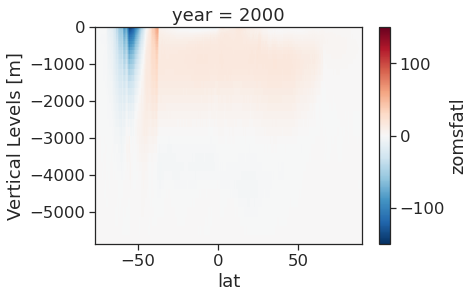

In [23]:
_amoc1[0,:,:].sortby('lat').plot(x='lat',y='depthw')

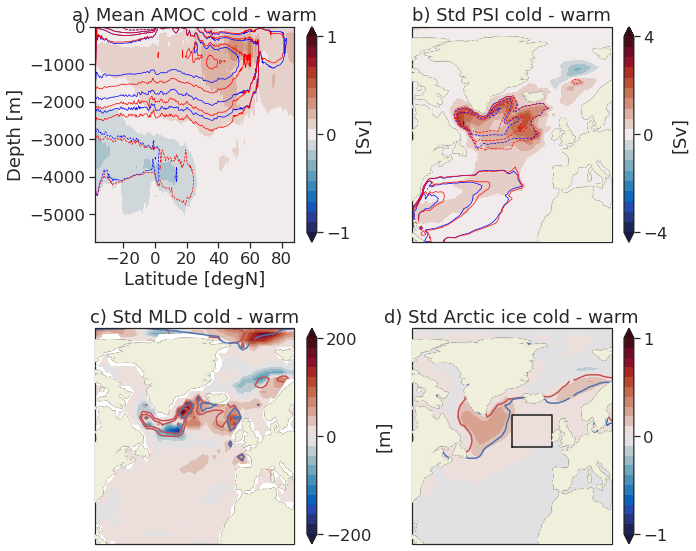

In [31]:
fig = plt.figure( figsize=(10,8) )

bg_color = 'Gainsboro'
lglobal = False

axs = []
axs.append( fig.add_subplot(2,2,1) )
axs.append( fig.add_subplot(2,2,2, projection=ccrs.PlateCarree()) )
axs.append( fig.add_subplot(2,2,3, projection=ccrs.PlateCarree()) )
axs.append( fig.add_subplot(2,2,4, projection=ccrs.PlateCarree()) )

if 1:
    ##
    ## Mean AMOC
    ##
    mlevels = np.array([-50,-30,-20,-15,-10,-5,-2,2,5,10,15,20,30,50])
    mlevels2 = np.linspace(-3,3,20)
    cbar_kwargs = {'label':'[Sv]', 'ticks':[mlevels2[0],0,mlevels2[-1]]}
    #amoc_diff.plot.contourf(ax=axs[0], levels=mlevels2, extend='both',
    #                        cmap=cmocean.cm.balance,
    #                        cbar_kwargs=cbar_kwargs)
    _amoc2.mean('year').sortby('lat').plot.contour(ax=axs[0], x='lat', y='depthw',
                                                   colors='blue',levels=mlevels,linewidths=0.7)
    _amoc1.mean('year').sortby('lat').plot.contour(ax=axs[0], x='lat', y='depthw',
                                                   colors='red',levels=mlevels,linewidths=0.7)
    axs[0].set_facecolor(bg_color)
    axs[0].set_xlim([-38,88])
    axs[0].set_xticks([-20,0,20,40,60,80])

    mlevels2 = np.linspace(-1,1,20)
    cbar_kwargs = {'label':'[Sv]', 'ticks':[mlevels2[0],0,mlevels2[-1]]}
    amoc_std_diff.sortby('lat').plot.contourf(ax=axs[0], x='lat', y='depthw',
                                              levels=mlevels2, extend='both',
                                              cbar_kwargs=cbar_kwargs,
                                              cmap=cmocean.cm.balance)
    axs[0].set_title('a) Mean AMOC cold - warm' )
    axs[0].set_ylabel('Depth [m]')
    axs[0].set_xlabel('Latitude [degN]')
    
    ##
    ## Mean barotropic
    ##
    mlevels = np.array([-150,-100,-80,-50,-30,-20,-10,10,20,30,50,80,100,150])
    mlevels2 = np.linspace(-10,10,20)
    cbar_kwargs = {'label':'[Sv]', 'ticks':[mlevels2[0],0,mlevels2[-1]]}
    #baro_diff.plot.contourf(ax=axs[1], levels=mlevels2, 
    #                        extend='both', rasterized=True,
    #                        cmap=cmocean.cm.balance,
    #                        cbar_kwargs=cbar_kwargs)
    _baro2.mean('year').plot.contour(ax=axs[1],colors='blue',levels=mlevels,linewidths=0.7)
    _baro1.mean('year').plot.contour(ax=axs[1],colors='red',levels=mlevels,linewidths=0.7)
    axs[1].set_title('b) Mean PSI cold - warm' )
    axs[1].set_facecolor(bg_color)
    
    cdata, clon = cutil.add_cyclic_point(baro_std_diff, coord=baro_std_diff.lon)
    clat = baro_std_diff.lat
    
    mlevels2 = np.linspace(-4,4,20)
    cf = axs[1].contourf(clon, clat, cdata, 
                    levels=mlevels2, extend='both',
                    cmap=cmocean.cm.balance)
    cb = plt.colorbar(cf, ax=axs[1])
    cb.set_ticks([mlevels2[0],0,mlevels2[-1]])
    cb.set_label('[Sv]')
    axs[1].set_title('b) Std PSI cold - warm')
    #axs[1].set_facecolor(bg_color)
    #axs[1].set_xlabel('')
    #axs[1].set_xticklabels([])
    #axs[1].set_ylabel('')
    #axs[1].set_yticklabels([])
    axs[1].add_feature(cfeature.LAND, zorder=100)
    axs[1].coastlines()
    if lglobal:
        axs[1].set_global()
    else:
        axs[1].set_extent([-80, 20, 20, 85])
    axs[1].set_aspect('auto')
    
    ##
    ## Mean MLD
    ##
    mld_levels = [400, 800, 1600]
    
    if lglobal:
        mld_levels2 = np.linspace(-100, 100, 21)
        _z1 = _mld1_y.mean('year')
        _z2 = _mld2_y.mean('year')
    else:
        mld_levels2 = np.linspace(-200, 200, 21)
        _z1 = _mld1.mean('year')
        _z2 = _mld2.mean('year')
        
    _z1.plot.contour(ax=axs[2], 
                     levels=mld_levels,
                     colors='r')
    _z2.plot.contour(ax=axs[2], 
                     levels=mld_levels,
                     colors='b')
    
    if lglobal:
        cdata, clon = cutil.add_cyclic_point(mld_std_diff_y, coord=mld_std_diff_y.lon)
        clat = mld_std_diff_y.lat
    else:
        cdata, clon = cutil.add_cyclic_point(mld_std_diff, coord=mld_std_diff.lon)
        clat = mld_std_diff.lat
        
    cf = axs[2].contourf(clon, clat, cdata, 
                    levels=mld_levels2, extend='both',
                    cmap=cmocean.cm.balance)
    cb = plt.colorbar(cf, ax=axs[2])
    cb.set_ticks([mld_levels2[0],0,mld_levels2[-1]])
    cb.set_label('[m]')
    
    axs[2].add_feature(cfeature.LAND, zorder=100)
    if lglobal:
        axs[2].set_global()
    else:
        axs[2].set_extent([-80, 20, 20, 85])
        
    axs[2].coastlines()
    axs[2].set_aspect('auto')
    axs[2].set_title('c) Std MLD cold - warm')
    
    ##
    ## Sea ice
    ##
    ice_levels2 = np.linspace(-1, 1, 21)
    
    if lglobal:
        _z1 = _ice1y.mean('year')
        _z2 = _ice2y.mean('year')
    else:
        _z1 = _ice1.mean('year')
        _z2 = _ice2.mean('year')
        
    _z1.plot.contour(ax=axs[3], 
                     levels=[0.15],
                     colors='r')
    _z2.plot.contour(ax=axs[3], 
                     levels=[0.15],
                     colors='b')
    
    if lglobal:
        cdata, clon = cutil.add_cyclic_point(ice_std_diff_y, coord=ice_std_diff_y.lon)
        clat = ice_std_diff_y.lat
    else:
        cdata, clon = cutil.add_cyclic_point(ice_std_diff, coord=ice_std_diff.lon)
        clat = ice_std_diff.lat
        
    cf = axs[3].contourf(clon, clat, cdata, 
                    levels=ice_levels2, extend='both',
                    cmap=cmocean.cm.balance)
    cb = plt.colorbar(cf, ax=axs[3])
    cb.set_ticks([ice_levels2[0],0,ice_levels2[-1]])
    
    axs[3].add_feature(cfeature.LAND, zorder=100)
    if lglobal:
        axs[3].set_global()
    else:
        axs[3].set_extent([-80, 20, 20, 85])
        
    axs[3].coastlines()
    axs[3].set_aspect('auto')
    axs[3].set_title('d) Std Arctic ice cold - warm')
    
    # mark box for THF
    lon1, lon2, lat1, lat2 = -30, -10, 50, 60
    axs[3].plot([lon1,lon2,lon2,lon1,lon1],[lat1,lat1,lat2,lat2,lat1],'-k')
    
fig.tight_layout()
if lglobal:
    fig.savefig('figures/cold_warm_diff_AMOC_SPG_conv_ice_global%s.pdf' % (dark,),format='pdf',dpi=150)
else:
    fig.savefig('figures/cold_warm_diff_AMOC_SPG_conv_ice%s.pdf' % (dark,),format='pdf',dpi=150)

## Difference in atmospheric forcing

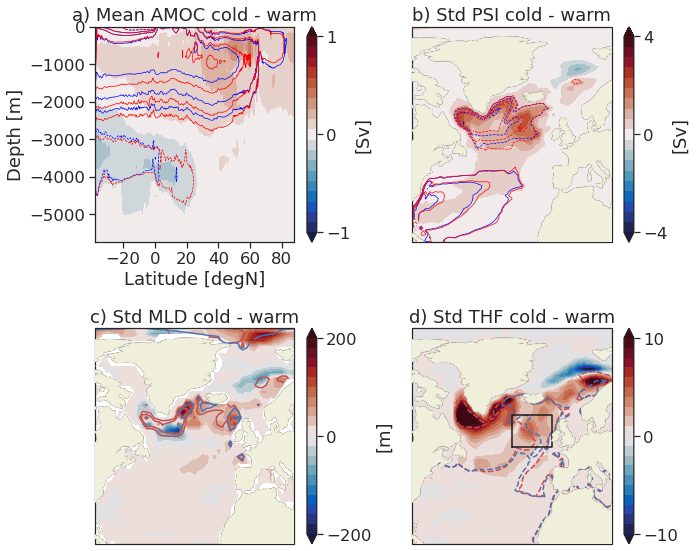

In [40]:
fig = plt.figure( figsize=(10,8) )

bg_color = 'Gainsboro'
lglobal = False

axs = []
axs.append( fig.add_subplot(2,2,1) )
axs.append( fig.add_subplot(2,2,2, projection=ccrs.PlateCarree()) )
axs.append( fig.add_subplot(2,2,3, projection=ccrs.PlateCarree()) )
axs.append( fig.add_subplot(2,2,4, projection=ccrs.PlateCarree()) )

if 1:
    ##
    ## Mean AMOC
    ##
    mlevels = np.array([-50,-30,-20,-15,-10,-5,-2,2,5,10,15,20,30,50])
    mlevels2 = np.linspace(-3,3,20)
    cbar_kwargs = {'label':'[Sv]', 'ticks':[mlevels2[0],0,mlevels2[-1]]}
    #amoc_diff.plot.contourf(ax=axs[0], levels=mlevels2, extend='both',
    #                        cmap=cmocean.cm.balance,
    #                        cbar_kwargs=cbar_kwargs)
    _amoc2.mean('year').sortby('lat').plot.contour(ax=axs[0], x='lat', y='depthw',
                                                   colors='blue',levels=mlevels,linewidths=0.7)
    _amoc1.mean('year').sortby('lat').plot.contour(ax=axs[0], x='lat', y='depthw',
                                                   colors='red',levels=mlevels,linewidths=0.7)
    axs[0].set_facecolor(bg_color)
    axs[0].set_xlim([-38,88])
    axs[0].set_xticks([-20,0,20,40,60,80])

    mlevels2 = np.linspace(-1,1,20)
    cbar_kwargs = {'label':'[Sv]', 'ticks':[mlevels2[0],0,mlevels2[-1]]}
    amoc_std_diff.sortby('lat').plot.contourf(ax=axs[0], x='lat', y='depthw',
                                              levels=mlevels2, extend='both',
                                              cbar_kwargs=cbar_kwargs,
                                              cmap=cmocean.cm.balance)
    axs[0].set_title('a) Mean AMOC cold - warm' )
    axs[0].set_ylabel('Depth [m]')
    axs[0].set_xlabel('Latitude [degN]')
    
    ##
    ## Mean barotropic
    ##
    mlevels = np.array([-150,-100,-80,-50,-30,-20,-10,10,20,30,50,80,100,150])
    mlevels2 = np.linspace(-10,10,20)
    cbar_kwargs = {'label':'[Sv]', 'ticks':[mlevels2[0],0,mlevels2[-1]]}
    #baro_diff.plot.contourf(ax=axs[1], levels=mlevels2, 
    #                        extend='both', rasterized=True,
    #                        cmap=cmocean.cm.balance,
    #                        cbar_kwargs=cbar_kwargs)
    _baro2.mean('year').plot.contour(ax=axs[1],colors='blue',levels=mlevels,linewidths=0.7)
    _baro1.mean('year').plot.contour(ax=axs[1],colors='red',levels=mlevels,linewidths=0.7)
    axs[1].set_title('b) Mean PSI cold - warm' )
    axs[1].set_facecolor(bg_color)
    
    cdata, clon = cutil.add_cyclic_point(baro_std_diff, coord=baro_std_diff.lon)
    clat = baro_std_diff.lat
    
    mlevels2 = np.linspace(-4,4,20)
    cf = axs[1].contourf(clon, clat, cdata, 
                    levels=mlevels2, extend='both',
                    cmap=cmocean.cm.balance)
    cb = plt.colorbar(cf, ax=axs[1])
    cb.set_ticks([mlevels2[0],0,mlevels2[-1]])
    cb.set_label('[Sv]')
    axs[1].set_title('b) Std PSI cold - warm')
    #axs[1].set_facecolor(bg_color)
    #axs[1].set_xlabel('')
    #axs[1].set_xticklabels([])
    #axs[1].set_ylabel('')
    #axs[1].set_yticklabels([])
    axs[1].add_feature(cfeature.LAND, zorder=100)
    axs[1].coastlines()
    if lglobal:
        axs[1].set_global()
    else:
        axs[1].set_extent([-80, 20, 20, 85])
    axs[1].set_aspect('auto')
    
    ##
    ## Mean MLD
    ##
    mld_levels = [400, 800, 1600]
    
    if lglobal:
        mld_levels2 = np.linspace(-100, 100, 21)
        _z1 = _mld1_y.mean('year')
        _z2 = _mld2_y.mean('year')
    else:
        mld_levels2 = np.linspace(-200, 200, 21)
        _z1 = _mld1.mean('year')
        _z2 = _mld2.mean('year')
        
    _z1.plot.contour(ax=axs[2], 
                     levels=mld_levels,
                     colors='r')
    _z2.plot.contour(ax=axs[2], 
                     levels=mld_levels,
                     colors='b')
    
    if lglobal:
        cdata, clon = cutil.add_cyclic_point(mld_std_diff_y, coord=mld_std_diff_y.lon)
        clat = mld_std_diff_y.lat
    else:
        cdata, clon = cutil.add_cyclic_point(mld_std_diff, coord=mld_std_diff.lon)
        clat = mld_std_diff.lat
        
    cf = axs[2].contourf(clon, clat, cdata, 
                    levels=mld_levels2, extend='both',
                    cmap=cmocean.cm.balance)
    cb = plt.colorbar(cf, ax=axs[2])
    cb.set_ticks([mld_levels2[0],0,mld_levels2[-1]])
    cb.set_label('[m]')
    
    axs[2].add_feature(cfeature.LAND, zorder=100)
    if lglobal:
        axs[2].set_global()
    else:
        axs[2].set_extent([-80, 20, 20, 85])
        
    axs[2].coastlines()
    axs[2].set_aspect('auto')
    axs[2].set_title('c) Std MLD cold - warm')
    
    ##
    ## Turb heat flux
    ##
    thf_levels2 = np.linspace(-10, 10, 21)
    
    _z1 = _thf1.mean('year')
    _z2 = _thf2.mean('year')
        
    _z1.plot.contour(ax=axs[3], 
                     levels=[-50],
                     colors='r')
    _z2.plot.contour(ax=axs[3], 
                     levels=[-50],
                     colors='b')
    
    if lglobal:
        cdata, clon = cutil.add_cyclic_point(thf_std_diff, coord=thf_std_diff.lon)
        clat = thf_std_diff.lat
    else:
        cdata, clon = cutil.add_cyclic_point(thf_std_diff, coord=thf_std_diff.lon)
        clat = thf_std_diff.lat
        
    cf = axs[3].contourf(clon, clat, cdata, 
                    levels=thf_levels2, extend='both',
                    cmap=cmocean.cm.balance)
    cb = plt.colorbar(cf, ax=axs[3])
    cb.set_ticks([thf_levels2[0],0,thf_levels2[-1]])
    
    axs[3].add_feature(cfeature.LAND, zorder=100)
    if lglobal:
        axs[3].set_global()
    else:
        axs[3].set_extent([-80, 20, 20, 85])
        
    axs[3].coastlines()
    axs[3].set_aspect('auto')
    axs[3].set_title('d) Std THF cold - warm')
    
    # mark box for THF
    lon1, lon2, lat1, lat2 = -30, -10, 50, 60
    axs[3].plot([lon1,lon2,lon2,lon1,lon1],[lat1,lat1,lat2,lat2,lat1],'-k')
    
fig.tight_layout()
if lglobal:
    fig.savefig('figures/cold_warm_diff_AMOC_SPG_conv_thf_global%s.pdf' % (dark,),format='pdf',dpi=150)
else:
    fig.savefig('figures/cold_warm_diff_AMOC_SPG_conv_thf%s.pdf' % (dark,),format='pdf',dpi=150)

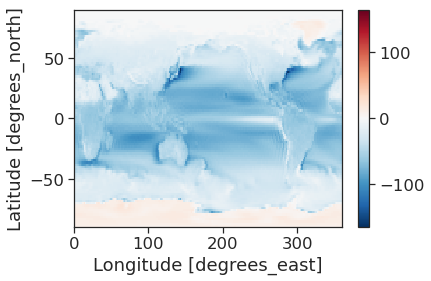

In [39]:
_z1.plot()

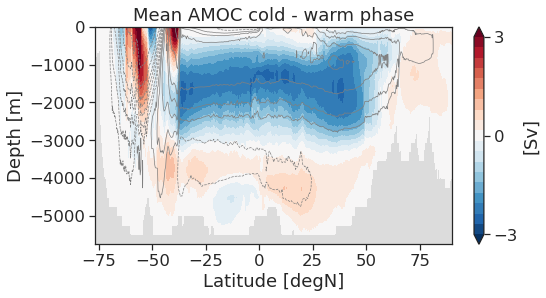

In [26]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

mlevels = np.array([-50,-30,-20,-15,-10,-5,-2,2,5,10,15,20,30,50])
mlevels2 = np.linspace(-3,3,20)
p = amoc_diff.where(amoc_diff != 0).plot.contourf(x='lat',y='depthw',ax=ax,levels=mlevels2,add_colorbar=False,extend='both')
_amoc1.mean('year').plot.contour(x='lat',y='depthw',ax=ax,colors='gray',levels=mlevels,linewidths=0.7)
ax.set_title('Mean AMOC cold - warm phase')
ax.set_facecolor(bg_color)
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Latitude [degN]')
cb = plt.colorbar(p, ax=ax)
cb.set_label('[Sv]')
cb.set_ticks([-3,0,3])
fig.savefig('figures/amoc_diff_cold_warm.pdf',format='pdf')

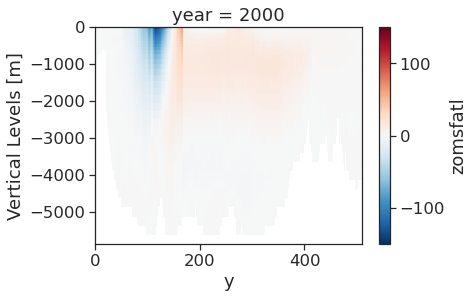

In [27]:

z = _amoc1.where(_amoc1 != 0).sortby('y')
z[0,:,:].plot()